In [1]:
from unityagents import UnityEnvironment
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
%config Completer.use_jedi = False

# Unity Environment

In [2]:
env = UnityEnvironment(file_name='Reacher.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


# Reinforcement Learning Algorithm 

## TD3


We are going to use Twin Delayed DDPG (TD3) to solve the Reacher environment

[paper](https://arxiv.org/abs/1802.09477)  
[code implemented by author](https://github.com/sfujim/TD3)  

## Components 

The TD3 agent consists of,
 - an actor network
 ```
 Actor(
  (network): Sequential(
    (0): Linear(in_features=33, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=4, bias=True)
    (5): Tanh()
  )
)
 ```
 - an actor target network
 - twinned critic networks
 
 ```
 Critic(
  (network1): Sequential(
    (0): Linear(in_features=37, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
  (network2): Sequential(
    (0): Linear(in_features=37, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)
 ```
 - twinned critic target networks
 
We also need a replay buffer to save experience tuples.
 
## Training Step

We do not want to start learning until we collect sufficient experience tuples. In this initial stage, we sample the action using uniform distribution. 

Once we have enough experiences to work with in the replay buffer. We can start training.

There are 3 main steps to train the TD3 agent:

1. Samples a batch of experience tuples (s, a, r, s', not_done_bool)
2. Critic learns by minimizing the TD error  
    2.1 Calculate the TD target
        With gradient calculation turned off,
        - Use actor target to select next action a'
          add noise and noise clip to a' for exploration 
        - Use critic target to get TD target = r + gamma * not_done_bool * Q(s', a')
          Here Q(s', a') is the minimum Q(s', a') of the twined critic target networks as 
    2.2 Calculate the prediction
        Get the twined prediction from the critic.
    2.3 Calculate the loss and backpropogate
        Loss = MSE(prediction 1 - TD target) + MSE(prediction 2 - TD Target)
3. Actor learns by maxmizing the expected return (state-action value) every 
   update_frequency steps  
    3.1 Calculate actor loss and backpropagate
        - Use the actor to select action a^ for current state s
        - Use 1 of the twined critic to calculate Q1(s, a^)
        - Minimize -mean(Q1(s, a^))
        
        Notice that we update the actor's weight (every update_frequency iteration) at a lower frequency than the critic. This is to reduce variance.
    3.2 Soft update actor target with the actor's weight; 
        soft update critic target with the critic's weight

# Training

In [5]:
from TD3 import ReplayBuffer, TD3

In [6]:
# initialize TD3 agent and replay buffer 

agent = TD3(
    state_dim=state_size, action_dim=action_size, max_action=1,
    action_noise=0.2, noise_clip=0.5, update_freq=2)

replay_buffer = ReplayBuffer(state_dim=state_size, action_dim=action_size)

In [9]:
max_timesteps = 1e6
eval_freq = 3
start_timesteps = 25e3
expl_noise = 0.1
max_action = 1
batch_size = 100

save_model = True
file_name = 'solution'

In [8]:
env_info = env.reset(train_mode=True)[brain_name] 
state, done = env_info.vector_observations, False
episode_reward = 0
episode_timesteps = 0
episode_num = 0
scores = []

start_time = datetime.now()
for t in range(int(max_timesteps)):

    episode_timesteps += 1

    # Select action randomly or according to policy
    if t < start_timesteps:
        action = np.random.uniform(low=-1,high=1,size=action_size)
    else:
        action = (
            agent.sample_action(np.array(state))
            + np.random.normal(0, max_action * expl_noise, size=action_size)
        ).clip(-max_action, max_action)

    # Perform action
    env_info = env.step(action)[brain_name]   
    next_state, reward, done = env_info.vector_observations, env_info.rewards[0], env_info.local_done[0]           
    done_bool = float(done) 

    # Store data in replay buffer
    replay_buffer.add(state, action, reward, next_state, done_bool)

    state = next_state
    episode_reward += reward

    # Train agent after collecting sufficient data
    if t >= start_timesteps:
        agent.train(replay_buffer, batch_size)

    if done: 
        scores.append(episode_reward)
        avg_score_of_last_100_episodes = np.array(scores)[-100:].mean()
        
        # +1 to account for 0 indexing. +0 on ep_timesteps since it will increment +1 even if done=True
        print(f"Total T: {t+1} Episode Num: {episode_num+1} Reward: {episode_reward:.3f}: Rolling Avg Reward: {avg_score_of_last_100_episodes:2f} Time: {(datetime.now() - start_time).seconds} seconds")
        # Reset environment
        env_info = env.reset(train_mode=True)[brain_name] 
        state, done = env_info.vector_observations, False
        
        episode_reward = 0
        episode_timesteps = 0
        episode_num += 1 
        
        start_time = datetime.now() 
          
        if avg_score_of_last_100_episodes > 31:
            np.save(f"./results/scores", scores)
            break

Total T: 1001 Episode Num: 1 Reward: 0.000: Rolling Avg Reward: 0.000000 Time: 1 seconds
Total T: 2002 Episode Num: 2 Reward: 0.000: Rolling Avg Reward: 0.000000 Time: 2 seconds
Total T: 3003 Episode Num: 3 Reward: 0.460: Rolling Avg Reward: 0.153333 Time: 1 seconds
Total T: 4004 Episode Num: 4 Reward: 0.000: Rolling Avg Reward: 0.115000 Time: 2 seconds
Total T: 5005 Episode Num: 5 Reward: 0.000: Rolling Avg Reward: 0.092000 Time: 2 seconds
Total T: 6006 Episode Num: 6 Reward: 0.730: Rolling Avg Reward: 0.198333 Time: 1 seconds
Total T: 7007 Episode Num: 7 Reward: 0.000: Rolling Avg Reward: 0.170000 Time: 1 seconds
Total T: 8008 Episode Num: 8 Reward: 0.000: Rolling Avg Reward: 0.148750 Time: 2 seconds
Total T: 9009 Episode Num: 9 Reward: 0.000: Rolling Avg Reward: 0.132222 Time: 2 seconds
Total T: 10010 Episode Num: 10 Reward: 0.280: Rolling Avg Reward: 0.147000 Time: 2 seconds
Total T: 11011 Episode Num: 11 Reward: 0.270: Rolling Avg Reward: 0.158182 Time: 2 seconds
Total T: 12012 Ep

Total T: 91091 Episode Num: 91 Reward: 9.570: Rolling Avg Reward: 3.615824 Time: 12 seconds
Total T: 92092 Episode Num: 92 Reward: 8.580: Rolling Avg Reward: 3.669783 Time: 12 seconds
Total T: 93093 Episode Num: 93 Reward: 12.420: Rolling Avg Reward: 3.763871 Time: 12 seconds
Total T: 94094 Episode Num: 94 Reward: 7.870: Rolling Avg Reward: 3.807553 Time: 12 seconds
Total T: 95095 Episode Num: 95 Reward: 8.800: Rolling Avg Reward: 3.860105 Time: 12 seconds
Total T: 96096 Episode Num: 96 Reward: 9.800: Rolling Avg Reward: 3.921979 Time: 12 seconds
Total T: 97097 Episode Num: 97 Reward: 7.970: Rolling Avg Reward: 3.963711 Time: 16 seconds
Total T: 98098 Episode Num: 98 Reward: 9.110: Rolling Avg Reward: 4.016224 Time: 15 seconds
Total T: 99099 Episode Num: 99 Reward: 10.520: Rolling Avg Reward: 4.081919 Time: 13 seconds
Total T: 100100 Episode Num: 100 Reward: 6.700: Rolling Avg Reward: 4.108100 Time: 13 seconds
Total T: 101101 Episode Num: 101 Reward: 10.690: Rolling Avg Reward: 4.21500

Total T: 178178 Episode Num: 178 Reward: 25.470: Rolling Avg Reward: 16.706100 Time: 12 seconds
Total T: 179179 Episode Num: 179 Reward: 24.540: Rolling Avg Reward: 16.861300 Time: 12 seconds
Total T: 180180 Episode Num: 180 Reward: 22.150: Rolling Avg Reward: 17.037400 Time: 12 seconds
Total T: 181181 Episode Num: 181 Reward: 29.520: Rolling Avg Reward: 17.269600 Time: 13 seconds
Total T: 182182 Episode Num: 182 Reward: 32.210: Rolling Avg Reward: 17.509600 Time: 13 seconds
Total T: 183183 Episode Num: 183 Reward: 23.140: Rolling Avg Reward: 17.659000 Time: 13 seconds
Total T: 184184 Episode Num: 184 Reward: 34.690: Rolling Avg Reward: 17.915000 Time: 12 seconds
Total T: 185185 Episode Num: 185 Reward: 23.680: Rolling Avg Reward: 18.065000 Time: 12 seconds
Total T: 186186 Episode Num: 186 Reward: 28.960: Rolling Avg Reward: 18.246200 Time: 12 seconds
Total T: 187187 Episode Num: 187 Reward: 23.320: Rolling Avg Reward: 18.380600 Time: 12 seconds
Total T: 188188 Episode Num: 188 Reward:

Total T: 264264 Episode Num: 264 Reward: 34.160: Rolling Avg Reward: 30.325599 Time: 14 seconds
Total T: 265265 Episode Num: 265 Reward: 38.520: Rolling Avg Reward: 30.424499 Time: 13 seconds
Total T: 266266 Episode Num: 266 Reward: 36.540: Rolling Avg Reward: 30.572099 Time: 14 seconds
Total T: 267267 Episode Num: 267 Reward: 35.710: Rolling Avg Reward: 30.713099 Time: 13 seconds
Total T: 268268 Episode Num: 268 Reward: 36.710: Rolling Avg Reward: 30.851199 Time: 12 seconds
Total T: 269269 Episode Num: 269 Reward: 29.610: Rolling Avg Reward: 30.861699 Time: 12 seconds
Total T: 270270 Episode Num: 270 Reward: 36.500: Rolling Avg Reward: 31.052199 Time: 12 seconds


## Reward

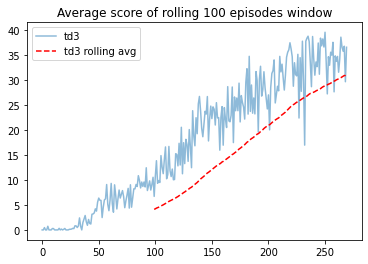

In [15]:
import matplotlib.pyplot as plt
import pandas as pd


plt.plot(scores, label='td3', alpha=0.5)
plt.plot(pd.Series(scores).rolling(100).mean(), '--', label='td3 rolling avg', color='red')
plt.title('Average score of rolling 100 episodes window')
plt.legend()
plt.show()

In [16]:
agent.save(f"./models/{file_name}")

## Trained Agent in Action

In [18]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = agent.sample_action(states) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 36.379999186843634


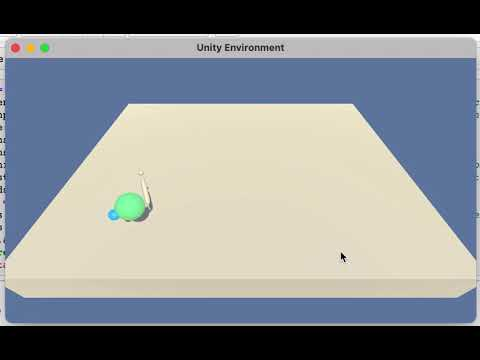

In [19]:
# https://youtu.be/v1SlXAKCuJ4

from IPython.display import YouTubeVideo
YouTubeVideo('v1SlXAKCuJ4')

# Future Improvement

Implement an learning algorithm that utilise distributed learning. For example, [PPO](https://arxiv.org/pdf/1707.06347.pdf), [A3C](https://arxiv.org/pdf/1602.01783.pdf), [D4PG](https://openreview.net/pdf?id=SyZipzbCb), [MADDPG](https://arxiv.org/pdf/1706.02275.pdf)
